In this workshop we will work on a project to construct a simulation of a gas in a 2d box. You may have seen something similar on your lectures though here our simulation will be a bit simpler.

We will be simulating an ideal gas so particles will collide with each other and the walls of the box in a perfectly elastic manner. The aim will be to simulate N particles, in a box of size L x L, given some initial conditions, namely the positions and momementa of the particles involved.

Once we have our simulation up and running we'll check the distribution of speeds and see if it corresponds to the distribution predicted by the 2d version of the Maxwell-Boltzmann distribution.

In [1]:
import numpy as np
from oo_functions import animate_trajectory, clunky_display_frame

In [2]:
import matplotlib.pyplot as plt 
%matplotlib nbagg

In [2]:
%load_ext Cython

In [3]:
class Vector(): 
    def __init__(self, i1,i2):
        self.x = i1 
        self.y = i2
    
    def __add__(self,other):
        return (Vector(self.x+other.x,self.y+other.y))

    def __sub__(self,other):
        return (Vector(self.x-other.x,self.y-other.y))

    def __mul__(self,other):
        return Vector(self.x*other,self.y*other)
    
    def __truediv__(self,other):
        return Vector(self.x/other,self.y/other)

    def __pow__(self,other):
        return Vector(self.x**other,self.y**other)
    
    def dot(self,other):
        return self.x*other.x + self.y*other.y
    
    def length(self):
        return np.sqrt(self.x**2 + self.y**2)

We're going to create two classes, a Particle class which will represent *drum roll* particles and a simulation class which will represent the total simulation and which include many instances of our particle class.

In the cell below construct a Particle class. 

Consider what attributes a single particle of ideal gas should have. How many properties are needed to define a particle of ideal gas?

Don't worry too much about methods for the moment. We'll return to those shortly just create the class give it some sensible attributes. Once you've created your class you'll want to create a list of 4 particle objects.

In [4]:
class Particle():
    def __init__(self, position, momentum, radius, mass):
        self.position = position
        self.momentum = momentum
        self.radius = radius
        self.mass = mass

Ok now we can create particles. But they aren't doing very much so now we need to think of our simulation class.

Below is a skeleton for the start of the simulation class. To get start your simulation you'll want to 

In [5]:
class Simulation():
    def __init__(self, no_steps, dt, particles):
        pass
    
    def update_positions(self):
        pass
    
    def simulate(self):
        pass

In [10]:
from numba import jitclass
from numba import float32

In [33]:
v=Vector(1.,2.)
u=Vector(3.,4.)


In [35]:
%%timeit
u.length()

The slowest run took 20.46 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.7 µs per loop


In [40]:
%%cython 
import numpy as np
class Vector(): 
    def __init__(self, i1,i2):
        self.x = i1 
        self.y = i2
    
    def __add__(self,other):
        return (Vector(self.x+other.x,self.y+other.y))

    def __sub__(self,other):
        return (Vector(self.x-other.x,self.y-other.y))

    def __mul__(self,other):
        return Vector(self.x*other,self.y*other)
    
    def __truediv__(self,other):
        return Vector(self.x/other,self.y/other)

    def __pow__(self,other):
        return Vector(self.x**other,self.y**other)
    
    def dot(self,other):
        return self.x*other.x + self.y*other.y
    
    def length(self):
        return np.sqrt(self.x**2 + self.y**2)
    
class Particle():
    def __init__(self, position, momentum, radius, mass):
        self.position = position
        self.momentum = momentum
        self.radius = radius
        self.mass = mass
        
    def velocity(self):
        return self.momentum/self.mass
    
    def overlap(self, other):
        displacement = self.position - other.position
        return displacement.length() < (self.radius + other.radius)

class Simulation():
    def __init__(self, no_particles, box_length, no_steps, dt, particles):
        self.box_length = box_length
        self.no_steps = no_steps
        self.no_particles = no_particles
        self.dt=dt
        self.particles = particles
        
        self.trajectory = []
        
    def update_positions(self):
        for particle in self.particles:
            particle.position += (particle.momentum/particle.mass)*self.dt

    def update_momenta(self):
        for i,particle in enumerate(self.particles):
            self.apply_box_collisions(particle)
            self.apply_particle_collisions(particle, i)

    def apply_box_collisions(self, particle):
        if (particle.position.x <0 and particle.momentum.x <0) or (particle.position.x > self.box_length and particle.momentum.x >0):
            particle.momentum.x *= -1

        if (particle.position.y <0 and particle.momentum.y <0) or (particle.position.y > self.box_length and particle.momentum.y >0):
            particle.momentum.y *= -1
           
    def apply_particle_collisions(self, particle, i):
        for j,other_particle in enumerate(self.particles):
            if j > i and particle.overlap(other_particle):
                delta_position = other_particle.position - particle.position
                collision_axis = delta_position / delta_position.length()

                particle_axis_momentum = collision_axis * particle.momentum.dot(collision_axis)
                other_particle_axis_momentum = collision_axis * other_particle.momentum.dot(collision_axis)
                
                #are they moving towards each other?
                delta_momentum = other_particle.momentum - particle.momentum
                if delta_momentum.dot(collision_axis) <= 0:
                    particle.momentum = particle.momentum - particle_axis_momentum + other_particle_axis_momentum
                    other_particle.momentum = other_particle.momentum - other_particle_axis_momentum + particle_axis_momentum
    
    def simulate(self):
        for step in range(self.no_steps):
            self.trajectory.append([p.position for p in self.particles])
            self.update_positions()
            self.update_momenta()
            #clunky_display_frame(self)

In [41]:
sim_case = []

box_length = 100
no_steps = 200
no_particles = 100

for i in range(no_particles):
    x = np.random.random()*box_length
    y = np.random.random()*box_length

    mx = 0.5 * box_length*3
    my = 0.5 * box_length*3

    position_vector = Vector(x,y)
    momentum_vector = Vector(mx,my)

    p = Particle(position=position_vector, momentum=momentum_vector,radius=1,mass=1)
    sim_case.append(p)

s=Simulation(no_particles=no_particles,box_length=box_length,no_steps=no_steps,dt=0.001, particles=sim_case)

In [42]:
%%timeit
s.simulate()

1 loops, best of 3: 9 s per loop


In [7]:
animate_trajectory(s)

/home/clyde/anaconda/envs/py3k/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/clyde/anaconda/envs/py3k/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
#!/usr/bin/env python

import numpy as np
import time
import matplotlib
matplotlib.use('GTKAgg')
from matplotlib import pyplot as plt


def randomwalk(dims=(256, 256), n=20, sigma=5, alpha=0.95, seed=1):
    """ A simple random walk with memory """

    r, c = dims
    gen = np.random.RandomState(seed)
    pos = gen.rand(2, n) * ((r,), (c,))
    old_delta = gen.randn(2, n) * sigma

    while True:
        delta = (1. - alpha) * gen.randn(2, n) * sigma + alpha * old_delta
        pos += delta
        for ii in xrange(n):
            if not (0. <= pos[0, ii] < r):
                pos[0, ii] = abs(pos[0, ii] % r)
            if not (0. <= pos[1, ii] < c):
                pos[1, ii] = abs(pos[1, ii] % c)
        old_delta = delta
        yield pos


def run(niter=1000, doblit=True):
    """
    Display the simulation using matplotlib, optionally using blit for speed
    """

    fig, ax = plt.subplots(1, 1)
    ax.set_aspect('equal')
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.hold(True)
    rw = randomwalk()
    x, y = rw.next()

    plt.show(False)
    plt.draw()

    if doblit:
        # cache the background
        background = fig.canvas.copy_from_bbox(ax.bbox)

    points = ax.plot(x, y, 'o')[0]
    tic = time.time()

    for ii in xrange(niter):

        # update the xy data
        x, y = rw.next()
        points.set_data(x, y)

        if doblit:
            # restore background
            fig.canvas.restore_region(background)

            # redraw just the points
            ax.draw_artist(points)

            # fill in the axes rectangle
            fig.canvas.blit(ax.bbox)

        else:
            # redraw everything
            fig.canvas.draw()

    plt.close(fig)
    print "Blit = %s, average FPS: %.2f" % (
        str(doblit), niter / (time.time() - tic))

if __name__ == '__main__':
    run(doblit=False)
    run(doblit=True)

In [52]:
box_length = 100
no_steps = 500

p1 = Particle(position = Vector(20,20), momentum=Vector(0,100),radius=1,mass=1)
p2 = Particle(position = Vector(20,25), momentum=Vector(0,0),radius=1,mass=1)

p3 = Particle(position = Vector(50,20), momentum=Vector(100,100),radius=1,mass=1)
p4 = Particle(position = Vector(55,25), momentum=Vector(0,0),radius=1,mass=1)

p5 = Particle(position = Vector(20,55), momentum=Vector(100,0),radius=1,mass=1)
p6 = Particle(position = Vector(25,50), momentum=Vector(0,100),radius=1,mass=1)

p7 = Particle(position = Vector(50,50), momentum=Vector(100,0),radius=1,mass=1)
p8 = Particle(position = Vector(55,50), momentum=Vector(0,0),radius=1,mass=1)

test_case = [p1,p2,p3,p4,p5,p6,p7,p8]
s=Simulation(no_particles=8,box_length=100,no_steps=no_steps,dt=0.0005,particles=test_case)
s.simulate()
animate_trajectory(s)

<IPython.core.display.Javascript object>


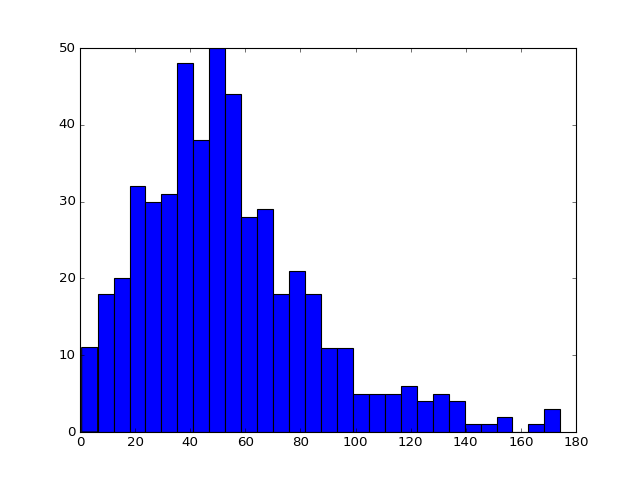

In [147]:
s.display_final_speeds(30)

<IPython.core.display.Javascript object>


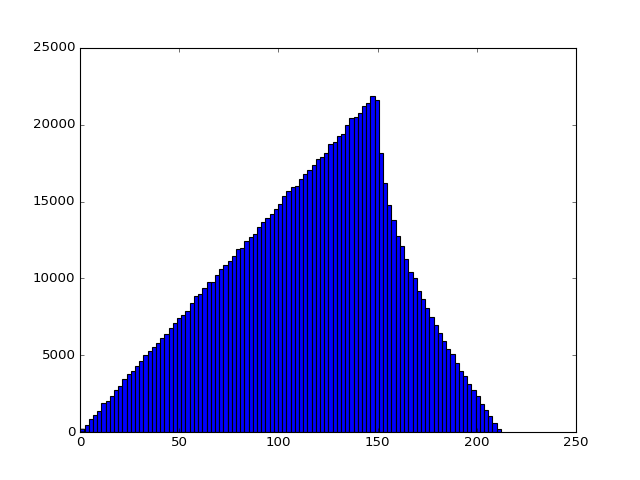

In [153]:
#what distribution do we start with?

test_vs = [(np.random.random(2)-0.5) * 100*3 for _ in range(1000000)]
test_s = [np.linalg.norm(v) for v in test_vs]

plt.figure()
plt.hist(test_s,bins=100)
plt.show()

<IPython.core.display.Javascript object>


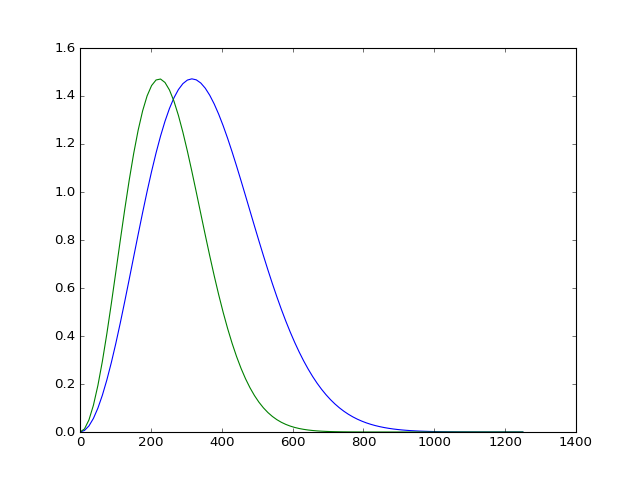

In [144]:
from scipy.stats import maxwell

plt.figure()
x = np.linspace(0,1250,100)
#scale = sqrt(kT/m)
#k/m for neon ~500 
#@~300k scale ~= 387
# 2500 ms^-1 ~= 350 x
# 1x = 7.5 ms^-1
# radius = 15m!
# neon radius 

##2d maxwell scale = m/2kt
# neon = 1e-5
maxwell_2d = lambda v,a: 4*np.pi*v**2*(a/np.pi)*np.e**(-a*v**2)
#plt.plot(x,maxwell.pdf(x,scale=387))
plt.plot(x,maxwell_2d(x,1e-5))
plt.plot(x,maxwell_2d(x,2e-5))

plt.show()

##doubling mass -> peak shrinks by 33%
##same seen in simulation! :)

In [ ]:
plt.plot(*zip(*s.positions[10]),marker='o', linestyle='', markersize=15)
plt.show()

In [ ]:
np.array(zip(*s.positions[0])) - np.array(s.positions[0]).T

In [ ]:


class Test(object):   
    def __init__(self):
        pass
    
    def anim(self):
        def update_line(num, data, line):
            line.set_data(data[..., :num])
            return line,
        
        fig = plt.figure()

        data = np.random.rand(2, 25)
        l, = plt.plot([], [], linestyle='', marker='o')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel('x')
        plt.title('test')
        line_ani = animation.FuncAnimation(fig, update_line, 25, fargs=(data, l),
                                           interval=50, blit=True)
        return line_ani
    
    def other(self):
        return self.anim()

In [ ]:
# Test()
# a.other()